# AI-Driven Logistics Risk Predictor & Delivery Optimization

# Import & Install

In [ ]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Extract, Transform, Load (ETL)

### Config & Settings Up

In [ ]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

FILES = {
    'lpi': 'LPI_2014-2018.csv',
    'fuel': 'Global_Fuel_Prices_Database.csv',
    'dataco': 'DataCoSupplyChainDataset.csv' # Ganti jika nama file utama Anda berbeda
}

# Mapping untuk LPI (Tahun DataCo -> Tahun LPI yang tersedia)
# Logika: Gunakan data LPI tahun yang sama atau tahun survei sebelumnya yang terdekat
LPI_YEAR_MAPPING = {
    2015: 2014,
    2016: 2016,
    2017: 2016,
    2018: 2018,
    2019: 2018
}

# Indeks Kolom LPI yang akan diambil (Berdasarkan analisis struktur file)
LPI_COLUMN_INDICES = [0, 1, 2, 3, 10, 12, 14, 16, 18, 20]

# Nama kolom baru untuk LPI agar rapi
LPI_NEW_COLUMNS = [
    'Country', 'Country_Code', 'Year', 
    'LPI_Score', 'LPI_Customs', 'LPI_Infrastructure', 
    'LPI_Intl_Shipments', 'LPI_Logistics_Quality', 
    'LPI_Tracking', 'LPI_Timeliness'
]

### Declare & Utils

In [ ]:
def process_fuel_data(file_path):
    """
    Membersihkan data Fuel:
    1. Filter USD/litre
    2. Melt dari Wide ke Long format
    3. Cleaning angka & tanggal
    4. Agregasi Rata-rata per Negara per Bulan
    """
    print(f"[Fuel] Processing file: {file_path}...")
    
    # Read CSV
    df = pd.read_csv(file_path, sep=';', on_bad_lines='skip')
    
    # Filter USD only
    df = df[df['Converted Units'] == 'USD/litre'].copy()
    
    # Identify Date Columns (columns containing '-')
    date_cols = [c for c in df.columns if '-' in c]
    
    # Melt: Transform columns to rows
    df_melt = df.melt(id_vars=['Country'], value_vars=date_cols, 
                      var_name='Month_Year', value_name='Fuel_Price')
    
    # Clean Numbers (Comma to Dot)
    df_melt['Fuel_Price'] = df_melt['Fuel_Price'].astype(str).str.replace(',', '.')
    df_melt['Fuel_Price'] = pd.to_numeric(df_melt['Fuel_Price'], errors='coerce')
    
    # Convert Date
    df_melt['Date_Obj'] = pd.to_datetime(df_melt['Month_Year'], format='%b-%y')
    
    # Aggregate: Mean per Country per Month (Handles duplicates & regions)
    df_final = df_melt.groupby(['Country', 'Date_Obj'])['Fuel_Price'].mean().reset_index()
    
    # Rename for easier merging later
    df_final.rename(columns={'Date_Obj': 'Join_Month_Date', 'Country': 'Join_Country'}, inplace=True)
    
    print(f"[Fuel] Done. Rows: {len(df_final)}")
    return df_final


def process_lpi_data(file_path):
    """
    Membersihkan data LPI:
    1. Skip header yang rusak
    2. Ambil kolom spesifik (Score saja)
    3. Cleaning angka
    """
    print(f"[LPI] Processing file: {file_path}...")
    
    # Read raw to handle multi-header
    df = pd.read_csv(file_path, sep=';', header=None)
    
    # Skip first 2 rows (headers), keep data
    df_clean = df.iloc[2:].copy()
    
    # Select columns by index
    df_clean = df_clean.iloc[:, LPI_COLUMN_INDICES]
    
    # Rename columns
    df_clean.columns = LPI_NEW_COLUMNS
    
    # Clean Numeric Columns
    numeric_cols = LPI_NEW_COLUMNS[3:] # All LPI_ columns
    for col in numeric_cols:
        df_clean[col] = df_clean[col].astype(str).str.replace(',', '.').astype(float)
        
    # Cast Year
    df_clean['Year'] = df_clean['Year'].astype(int)
    
    # Rename for merging
    df_clean.rename(columns={'Year': 'Join_Year_LPI', 'Country': 'Join_Country'}, inplace=True)
    
    print(f"[LPI] Done. Rows: {len(df_clean)}")
    return df_clean


def load_and_prep_dataco(file_path):
    """
    Menyiapkan Data Utama DataCo:
    1. Load Data
    2. Convert DateTime
    3. Buat Key Columns untuk Joining (Month & Year)
    """
    print(f"[DataCo] Loading main dataset: {file_path}...")
    
    # DataCo dataset usually has encoding issues, try latin-1 if utf-8 fails
    try:
        df = pd.read_csv(file_path, encoding='latin-1')
    except UnicodeDecodeError:
        df = pd.read_csv(file_path, encoding='utf-8')
        
    # Standardize Column Names (Optional: make lower case or replace spaces)
    # df.columns = [c.replace(' ', '_').lower() for c in df.columns] 
    
    # Convert Order Date to DateTime
    # Pastikan nama kolom tanggal benar. Biasanya 'Order date (DateOrders)' atau 'order date (DateOrders)'
    date_col_name = [c for c in df.columns if 'date' in c.lower() and 'order' in c.lower()][0]
    print(f"[DataCo] Detected Date Column: {date_col_name}")
    
    df['Order_Date_Dt'] = pd.to_datetime(df[date_col_name])
    
    # CREATE JOIN KEYS
    
    # 1. Key untuk Fuel (First day of month)
    df['Join_Month_Date'] = df['Order_Date_Dt'].dt.to_period('M').dt.to_timestamp()
    
    # 2. Key untuk LPI (Year Mapping)
    df['Original_Year'] = df['Order_Date_Dt'].dt.year
    df['Join_Year_LPI'] = df['Original_Year'].map(LPI_YEAR_MAPPING)
    
    # Handle Country Name Normalization (Basic)
    # Pastikan nama kolom negara benar. Biasanya 'Order Country'
    country_col = 'Order Country' 
    if country_col in df.columns:
        df['Join_Country'] = df[country_col].str.strip() # Remove spaces
    else:
        print(f"WARNING: Column '{country_col}' not found. Check dataframe columns.")
        
    print(f"[DataCo] Done. Rows: {len(df)}")
    return df

In [ ]:
def etl_pipeline():
    # 1. Process External Data
    df_fuel = process_fuel_data(FILES['fuel'])
    df_lpi = process_lpi_data(FILES['lpi'])
    
    # 2. Process Main Data
    # NOTE: Pastikan file 'DataCoSupplyChainDataset.csv' ada di folder yang sama
    # Jika Anda belum punya filenya di environment ini, upload dulu atau ganti pathnya
    try:
        df_dataco = load_and_prep_dataco(FILES['dataco'])
    except FileNotFoundError:
        print("ERROR: File DataCoSupplyChainDataset.csv tidak ditemukan. Pastikan file sudah diupload.")
        return None
    
    # 3. MERGING
    print("\n[Merging] Starting Left Joins...")
    
    # Merge 1: DataCo + LPI (on Country & Mapped Year)
    # Menggunakan Left Join agar data transaksi tidak hilang
    df_merged_1 = pd.merge(
        df_dataco,
        df_lpi,
        on=['Join_Country', 'Join_Year_LPI'],
        how='left'
    )
    
    # Merge 2: Result + Fuel (on Country & Month)
    df_final = pd.merge(
        df_merged_1,
        df_fuel,
        on=['Join_Country', 'Join_Month_Date'],
        how='left'
    )
    
    # 4. Final Cleanup
    # Drop kolom bantuan/join keys jika dirasa mengganggu (opsional)
    # cols_to_drop = ['Join_Month_Date', 'Join_Year_LPI', 'Country_Code']
    # df_final.drop(columns=cols_to_drop, inplace=True, errors='ignore')
    
    print(f"\n[Success] Pipeline Completed!")
    print(f"Original DataCo Rows: {len(df_dataco)}")
    print(f"Final Merged Rows : {len(df_final)}")
    
    # Check Missing Values Impact
    missing_fuel = df_final['Fuel_Price'].isna().sum()
    missing_lpi = df_final['LPI_Score'].isna().sum()
    
    print(f"Missing Fuel Prices: {missing_fuel} rows ({missing_fuel/len(df_final):.1%})")
    print(f"Missing LPI Scores : {missing_lpi} rows ({missing_lpi/len(df_final):.1%})")
    
    return df_final

### ETL Call

In [ ]:
if __name__ == "__main__":
    df_master = etl_pipeline()
    
    # Preview Data
    if df_master is not None:
        pd.set_option('display.max_columns', None)
        print("\nHead of Enriched Data:")
        display(df_master.head(3))

## Load Data

In [2]:
data_raw = pd.read_csv("../data/raw/DataCoSupplyChainDataset.csv", encoding='latin-1')
data_raw

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/15/2018 11:24,Standard Class
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,CASH,4,4,40.000000,399.980011,Shipping on time,0,45,Fishing,Brooklyn,...,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/20/2016 3:40,Standard Class
180515,DEBIT,3,2,-613.770019,395.980011,Late delivery,1,45,Fishing,Bakersfield,...,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/19/2016 1:34,Second Class
180516,TRANSFER,5,4,141.110001,391.980011,Late delivery,1,45,Fishing,Bristol,...,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/20/2016 21:00,Standard Class
180517,PAYMENT,3,4,186.229996,387.980011,Advance shipping,0,45,Fishing,Caguas,...,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/18/2016 20:18,Standard Class


# Sanity Check's

In [3]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

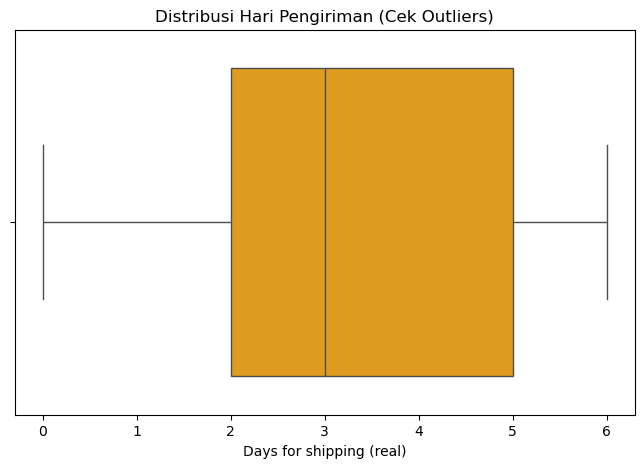

In [4]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=data_raw['Days for shipping (real)'], color='orange')
plt.title('Distribusi Hari Pengiriman (Cek Outliers)')
plt.show()

## Distributions Check

## Handle Missing Values

In [5]:
data_raw.isna().sum()

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


In [6]:
data_raw.columns[data_raw.isna().any()].tolist()

['Customer Lname', 'Customer Zipcode', 'Order Zipcode', 'Product Description']

/var/folders/5k/ryl7b4vx7nzdd92vwrlw_64r0000gn/T/ipykernel_4828/390598188.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=null_counts_filtered.index, y=null_counts_filtered.values, palette='viridis')


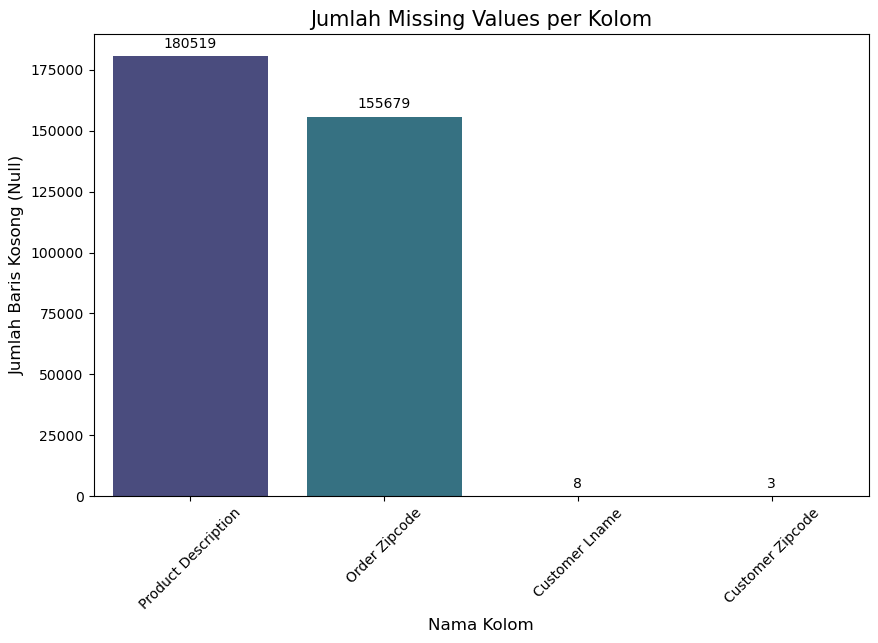

In [7]:

null_counts = data_raw.isna().sum()
null_counts_filtered = null_counts[null_counts > 0]
null_counts_filtered = null_counts_filtered.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=null_counts_filtered.index, y=null_counts_filtered.values, palette='viridis')


plt.title('Jumlah Missing Values per Kolom', fontsize=15)
plt.ylabel('Jumlah Baris Kosong (Null)', fontsize=12)
plt.xlabel('Nama Kolom', fontsize=12)
plt.xticks(rotation=45) 


for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.show()

### Hyptothesis of MCAR, MAR, or MCAR @ Customer Zipcode && @ Order Zipcode

In [8]:
null_zip = data_raw[data_raw['Customer Zipcode'].isna()]
print("Negara dengan Zipcode Null terbanyak:")
print(null_zip['Customer Country'].value_counts().head())

Negara dengan Zipcode Null terbanyak:
Customer Country
EE. UU.    3
Name: count, dtype: int64


In [9]:
null_order_zip = data_raw[data_raw['Order Zipcode'].isna()]

# Lihat sebaran negaranya (Top 10)
print("Negara dengan Order Zipcode Null terbanyak:")
print(null_order_zip['Order Country'].value_counts().head(10))

Negara dengan Order Zipcode Null terbanyak:
Order Country
Francia        13222
México         13172
Alemania        9564
Australia       8497
Brasil          7987
Reino Unido     7302
China           5758
Italia          4989
India           4783
Indonesia       4204
Name: count, dtype: int64


In [10]:
cols_check = ['Order Zipcode', 'Order City', 'Order State', 'Order Country']
check_completeness = data_raw[data_raw['Order Zipcode'].isna()][cols_check]

print(f"Total baris dengan Order Zipcode Null: {len(check_completeness)}")
print(f"Dari yang null itu, jumlah Order City yang JUGA null: {check_completeness['Order City'].isna().sum()}")
print(f"Dari yang null itu, jumlah Order State yang JUGA null: {check_completeness['Order State'].isna().sum()}")

Total baris dengan Order Zipcode Null: 155679
Dari yang null itu, jumlah Order City yang JUGA null: 0
Dari yang null itu, jumlah Order State yang JUGA null: 0


In [11]:
cols_to_drop = ['Customer Lname', 'Product Description', 'Order Zipcode']
data_clean = data_raw.drop(columns=cols_to_drop)
data_clean = data_clean.dropna()

print("Sisa Missing Values setelah pembersihan:")
print(data_clean.isna().sum().sum()) 
print(f"Ukuran Data Sekarang: {data_clean.shape}")

Sisa Missing Values setelah pembersihan:
0
Ukuran Data Sekarang: (180516, 50)


In [12]:
data_clean.columns[data_clean.isna().any()].tolist()

[]

## Standarization || Formatting data

In [13]:
data_clean

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order State,Order Status,Product Card Id,Product Category Id,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,Java Occidental,COMPLETE,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,Rajastán,PENDING,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,Rajastán,CLOSED,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,Queensland,COMPLETE,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,Queensland,PENDING_PAYMENT,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/15/2018 11:24,Standard Class
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,CASH,4,4,40.000000,399.980011,Shipping on time,0,45,Fishing,Brooklyn,...,Shanghái,CLOSED,1004,45,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/20/2016 3:40,Standard Class
180515,DEBIT,3,2,-613.770019,395.980011,Late delivery,1,45,Fishing,Bakersfield,...,Osaka,COMPLETE,1004,45,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/19/2016 1:34,Second Class
180516,TRANSFER,5,4,141.110001,391.980011,Late delivery,1,45,Fishing,Bristol,...,Australia del Sur,PENDING,1004,45,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/20/2016 21:00,Standard Class
180517,PAYMENT,3,4,186.229996,387.980011,Advance shipping,0,45,Fishing,Caguas,...,Australia del Sur,PENDING_PAYMENT,1004,45,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/18/2016 20:18,Standard Class


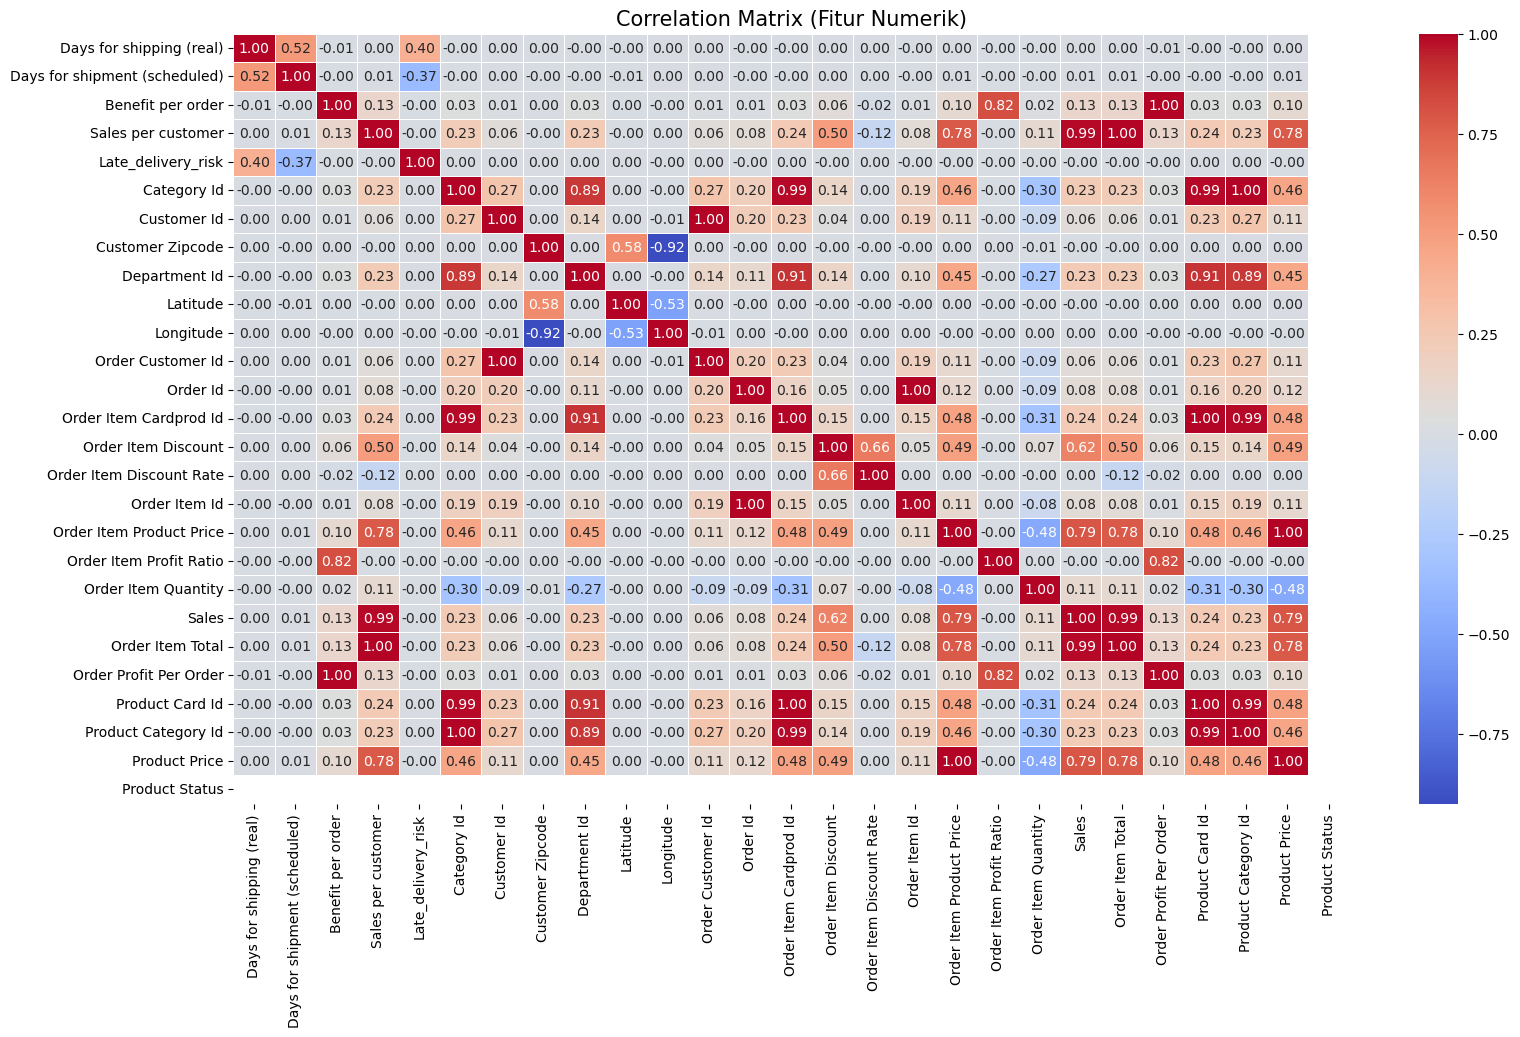

In [14]:
numeric_cols = data_clean.select_dtypes(include=[np.number])

# 2. Hitung korelasi
correlation_matrix = numeric_cols.corr()

# 3. Visualisasi Heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix (Fitur Numerik)', fontsize=15)
plt.show()

## Hypothesis

> Hipotesis "Apakah barang mahal "
> Bagaimana sebaran nilai transaksi? Apakah normal atau miring?
>
> Pada Grafik Distribusi terlihat sebaran data memiliki long tail dan berpusa pada transaksi < 600

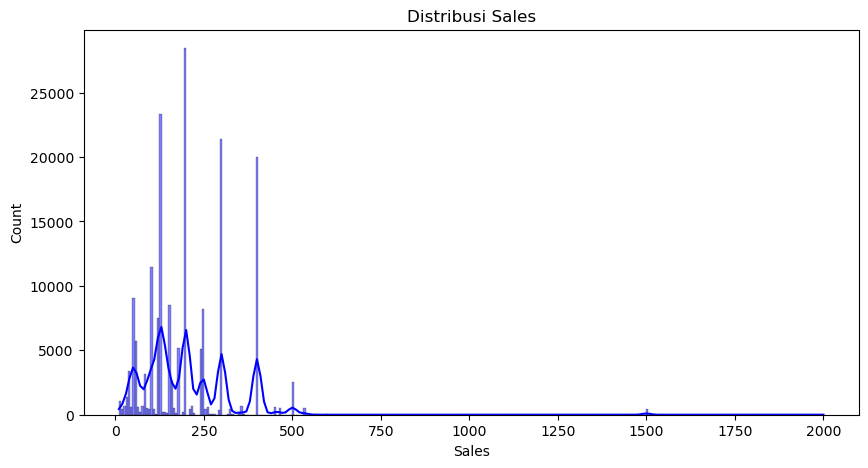

In [14]:
plt.figure(figsize=(10, 5))
sns.histplot(data_clean['Sales'], kde=True, color='blue')
plt.title('Distribusi Sales')
plt.show()

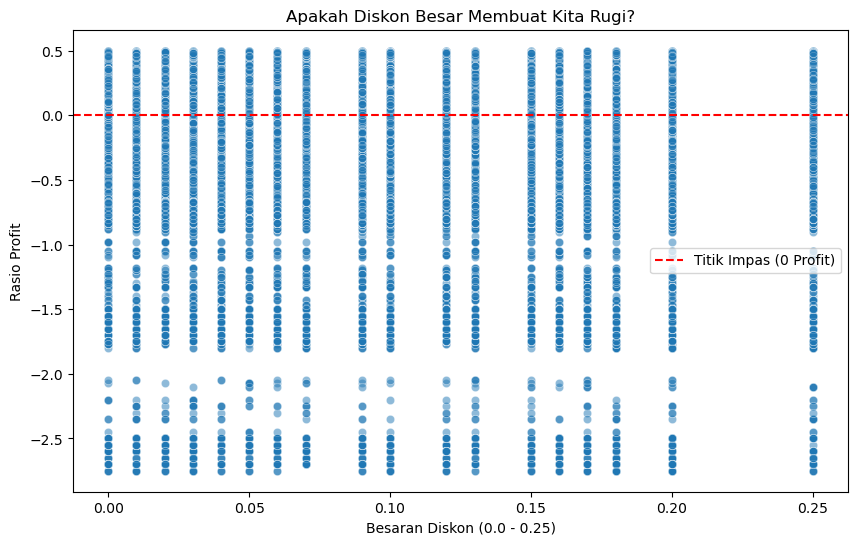

Order Item Discount Rate
0.00    26.666574
0.01    23.798760
0.02    23.675102
0.03    22.183212
0.04    23.400469
0.05    23.777867
0.06    24.071789
0.07    23.273000
0.09    22.910502
0.10    22.127961
0.12    20.914503
0.13    21.378961
0.15    20.059624
0.16    20.880197
0.17    19.331829
0.18    20.283454
0.20    17.680002
0.25    19.129471
Name: Benefit per order, dtype: float64


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hipotesis: Diskon besar menyebabkan kerugian
plt.figure(figsize=(10, 6))

# Scatter plot sederhana
sns.scatterplot(data=data_clean, x='Order Item Discount Rate', y='Order Item Profit Ratio', alpha=0.5)

# Garis batas profit 0 (Break Even Point)
plt.axhline(0, color='red', linestyle='--', label='Titik Impas (0 Profit)')

plt.title('Apakah Diskon Besar Membuat Kita Rugi?')
plt.xlabel('Besaran Diskon (0.0 - 0.25)')
plt.ylabel('Rasio Profit')
plt.legend()
plt.show()

# Cek rata-rata profit berdasarkan tingkat diskon
print(data_clean.groupby('Order Item Discount Rate')['Benefit per order'].mean())

/var/folders/5k/ryl7b4vx7nzdd92vwrlw_64r0000gn/T/ipykernel_4828/2743452517.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=risk_per_category.values, y=risk_per_category.index, palette='Reds_r')


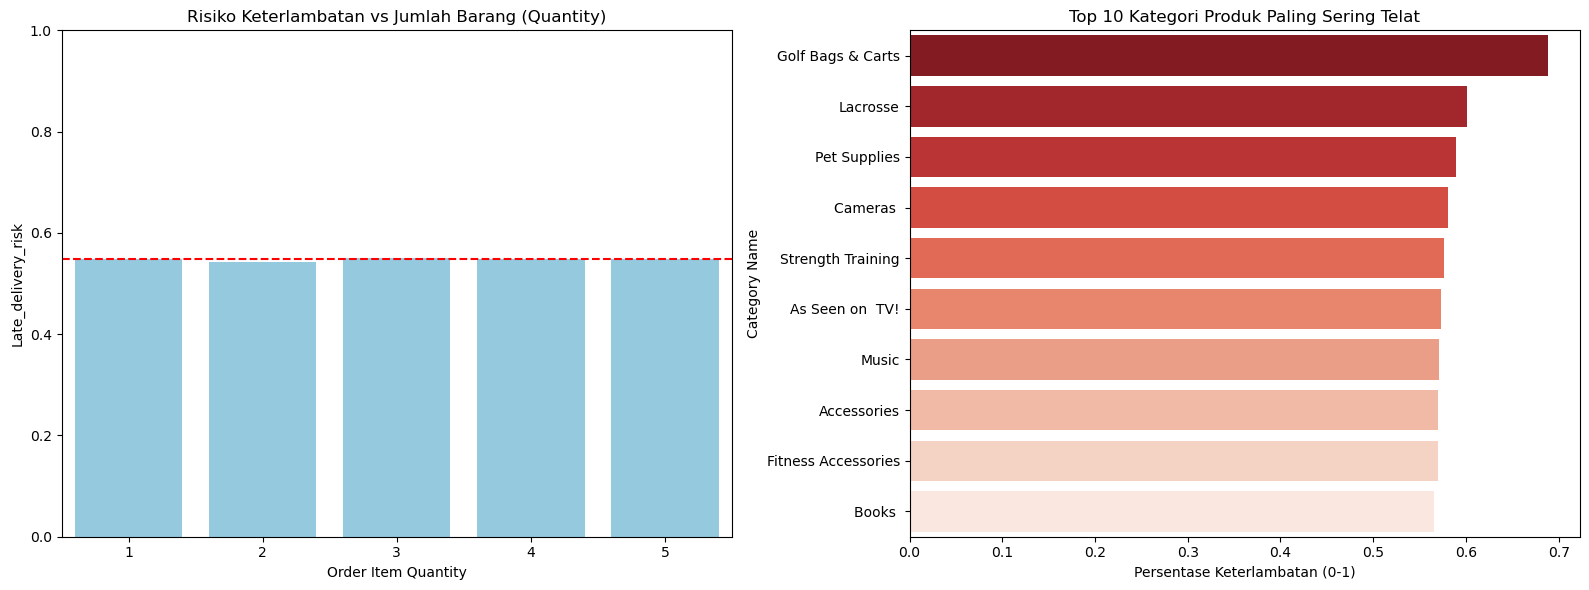

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Cek Pengaruh Quantity (Jumlah Barang)
# Apakah beli banyak bikin kurir telat?
sns.barplot(ax=axes[0], x='Order Item Quantity', y='Late_delivery_risk', data=data_clean, color='skyblue', errorbar=None)
axes[0].set_title('Risiko Keterlambatan vs Jumlah Barang (Quantity)')
axes[0].set_ylim(0, 1) # Skala risiko 0-1
axes[0].axhline(data_clean['Late_delivery_risk'].mean(), color='red', linestyle='--', label='Rata-rata Global')

# 2. Cek Pengaruh Kategori Produk (Top 10 Paling Berisiko)
# Kita cari kategori mana yang "Terkutuk"
risk_per_category = data_clean.groupby('Category Name')['Late_delivery_risk'].mean().sort_values(ascending=False).head(10)

sns.barplot(ax=axes[1], x=risk_per_category.values, y=risk_per_category.index, palette='Reds_r')
axes[1].set_title('Top 10 Kategori Produk Paling Sering Telat')
axes[1].set_xlabel('Persentase Keterlambatan (0-1)')

plt.tight_layout()
plt.show()

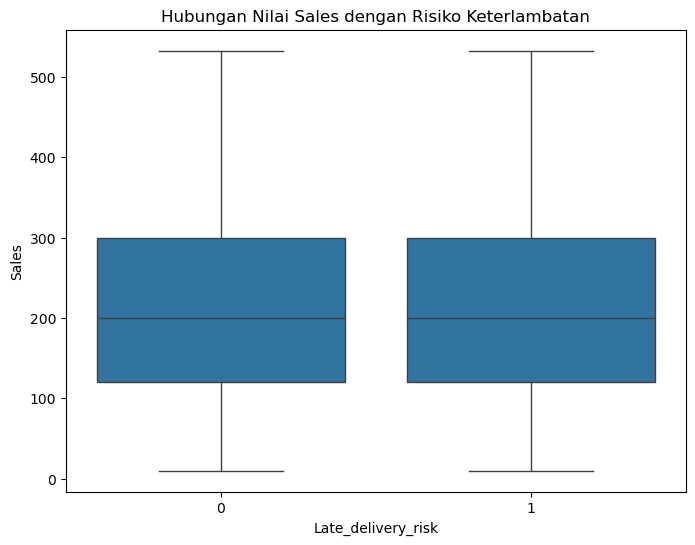

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(x='Late_delivery_risk', y='Sales', data=data_clean, showfliers=False)
plt.title('Hubungan Nilai Sales dengan Risiko Keterlambatan')
plt.show()

Price_Category
Murah (<$100)         55.248252
Sedang ($100-$300)    54.681758
Mahal (>$300)         54.853882
Name: Late_delivery_risk, dtype: float64


/var/folders/5k/ryl7b4vx7nzdd92vwrlw_64r0000gn/T/ipykernel_3075/1523300983.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delay_rate = data_clean.groupby('Price_Category')['Late_delivery_risk'].mean() * 100
/var/folders/5k/ryl7b4vx7nzdd92vwrlw_64r0000gn/T/ipykernel_3075/1523300983.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=delay_rate.index, y=delay_rate.values, palette='Blues')


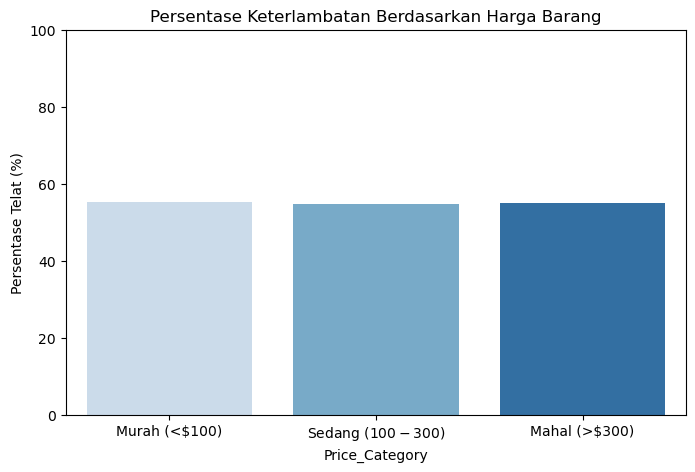

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Buat Kategori Harga (Binning)
# Murah: 0-100, Sedang: 100-300, Mahal: >300
data_clean['Price_Category'] = pd.cut(data_clean['Sales'], 
                                      bins=[0, 100, 300, 2000], 
                                      labels=['Murah (<$100)', 'Sedang ($100-$300)', 'Mahal (>$300)'])

# 2. Hitung Rata-rata Keterlambatan per Kategori
# (Angka 0.5 berarti 50% barang di kategori itu telat)
delay_rate = data_clean.groupby('Price_Category')['Late_delivery_risk'].mean() * 100

print(delay_rate)

# 3. Visualisasi Bar Chart Sederhana
plt.figure(figsize=(8, 5))
sns.barplot(x=delay_rate.index, y=delay_rate.values, palette='Blues')
plt.title('Persentase Keterlambatan Berdasarkan Harga Barang')
plt.ylabel('Persentase Telat (%)')
plt.ylim(0, 100) # Supaya skalanya jelas 0-100%
plt.show()

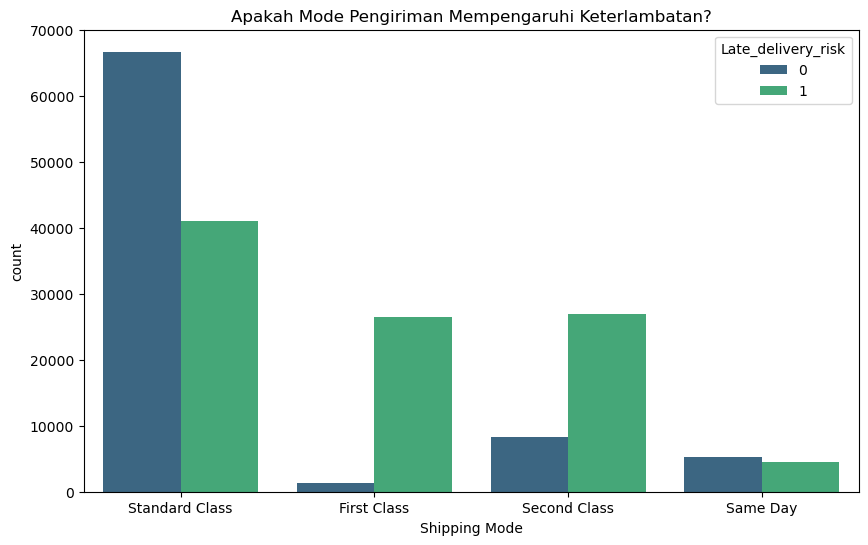

Shipping Mode
First Class       95.322331
Same Day          45.743042
Second Class      76.632781
Standard Class    38.072390
Name: Late_delivery_risk, dtype: float64


In [17]:
# Cek hubungan Mode Pengiriman dengan Risiko Telat
# Biasanya ini faktor penentu paling kuat
plt.figure(figsize=(10, 6))
sns.countplot(x='Shipping Mode', hue='Late_delivery_risk', data=data_clean, palette='viridis')
plt.title('Apakah Mode Pengiriman Mempengaruhi Keterlambatan?')
plt.show()

# Cek persentase keterlambatan per mode
print(data_clean.groupby('Shipping Mode')['Late_delivery_risk'].mean() * 100)

/var/folders/5k/ryl7b4vx7nzdd92vwrlw_64r0000gn/T/ipykernel_3075/3678130846.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Shipping Mode', y='delivery_gap', data=data_clean, palette='viridis')


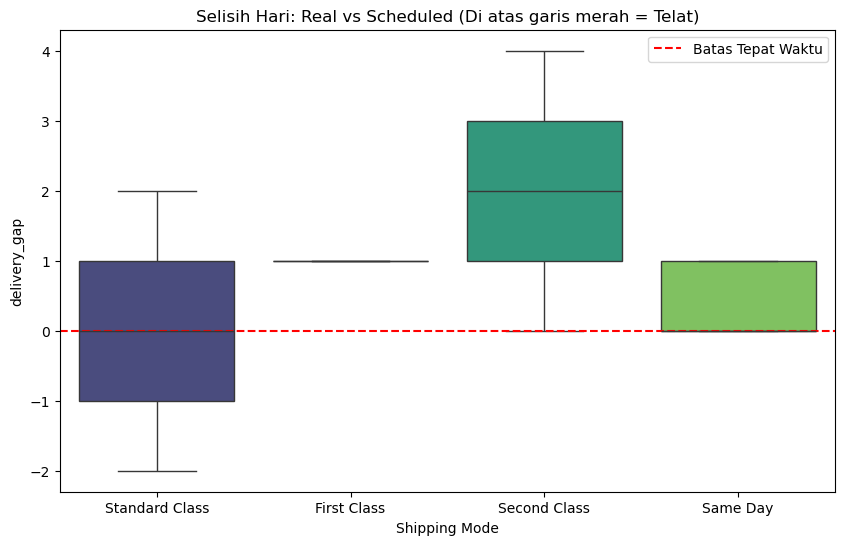

                Days for shipment (scheduled)  Days for shipping (real)
Shipping Mode                                                          
First Class                               1.0                  2.000000
Same Day                                  0.0                  0.478279
Second Class                              2.0                  3.990828
Standard Class                            4.0                  3.995907


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Jika positif (+), berarti telat. Jika negatif (-), berarti lebih cepat.
data_clean['delivery_gap'] = data_clean['Days for shipping (real)'] - data_clean['Days for shipment (scheduled)']

plt.figure(figsize=(10, 6))
sns.boxplot(x='Shipping Mode', y='delivery_gap', data=data_clean, palette='viridis')
plt.axhline(0, color='red', linestyle='--', label='Batas Tepat Waktu') # Garis batas 0
plt.title('Selisih Hari: Real vs Scheduled (Di atas garis merah = Telat)')
plt.legend()
plt.show()

print(data_clean.groupby('Shipping Mode')[['Days for shipment (scheduled)', 'Days for shipping (real)']].mean())

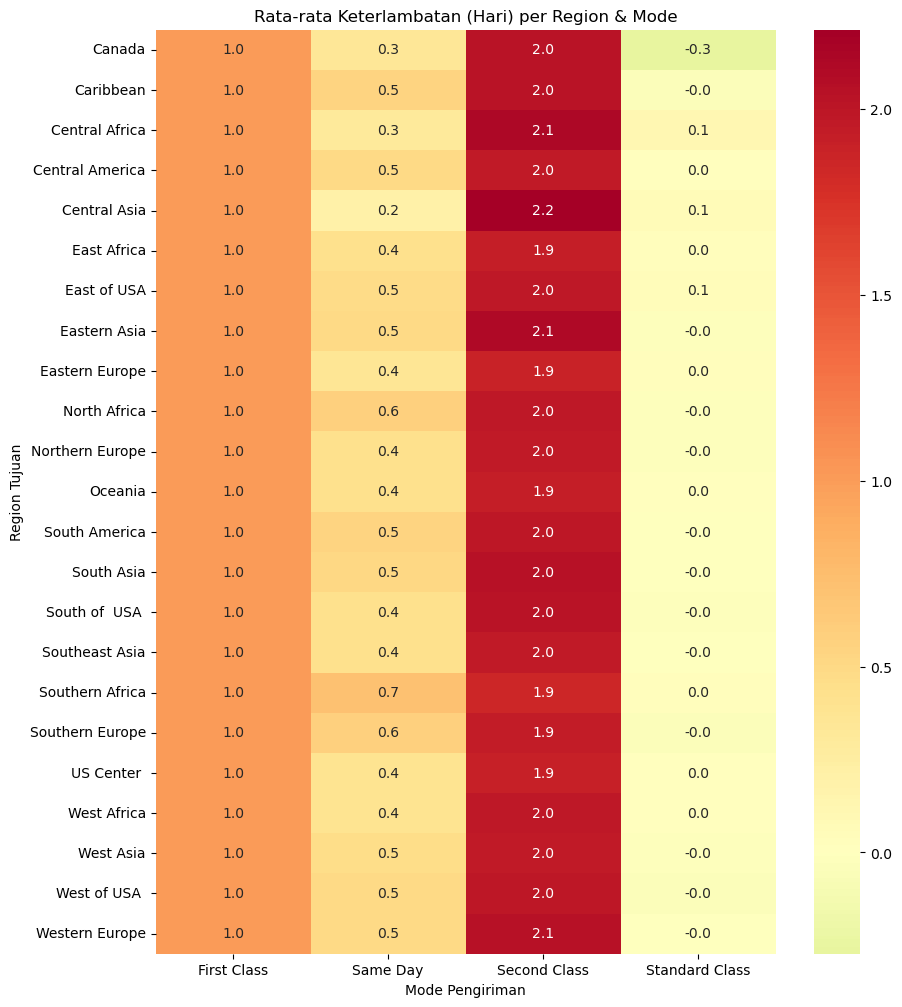

In [48]:
pivot_delay = data_clean.pivot_table(index='Order Region', 
                                     columns='Shipping Mode', 
                                     values='delivery_gap', 
                                     aggfunc='mean')

# Visualisasi Heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(pivot_delay, annot=True, cmap='RdYlGn_r', center=0, fmt=".1f")
plt.title('Rata-rata Keterlambatan (Hari) per Region & Mode')
plt.xlabel('Mode Pengiriman')
plt.ylabel('Region Tujuan')
plt.show()